In [21]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import numpy as np
import copy
from math import log10
from bioservices import UniProt
from collections import Counter
import random 
import warnings 
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import to_rgba
from matplotlib.lines import Line2D
warnings.filterwarnings("ignore")

In [34]:
file_path = "Dataset\PathLinker_2018_human-ppi-weighted-cap0_75.txt"
df = pd.read_csv(file_path, sep='\t')
df = df[:5000]
df.head()

,#tail,head,edge_weight,edge_type
0,Q8TBF5,Q9UKB1,0.311133,MI:0004 (affinity chromatography technology)
1,Q8TBF4,Q15717,0.311133,MI:0004 (affinity chromatography technology)
2,Q8TBF4,P08865,0.311133,MI:0004 (affinity chromatography technology)
3,Q8TBF4,Q02539,0.311133,MI:0004 (affinity chromatography technology)
4,Q8TBF4,Q96J01,0.201461,MI:0401 (biochemical)


In [9]:
# check for any missing data. 
df.isna().any().any() 


False

In [10]:
print(min(df["edge_weight"]))
print(max(df["edge_weight"]))

0.0
0.75


## Visualizing The Graph

In [35]:
PPI_graph = nx.DiGraph()
for i in range(len(df)):
    tail=df.loc[i,:][0] 
    head=df.loc[i,:][1]
    weight=df.loc[i,:][2] 
    PPI_graph.add_edge(tail,head,weight = weight)    
edge_weights = nx.get_edge_attributes(PPI_graph, 'weight')
#node color varies with Degree

In [20]:
def basic_net_stats(G):
    print(f"number of notes {G.number_of_nodes()}")
    print(f"number of edges {G.number_of_edges()}")
    degree_sequence = [d for n,d in G.degree()]
    print(f"average degree {(np.mean(degree_sequence)):.2f}")

def get_graph_hubs(G,k = 10):
    degree_sequence = dict(G.degree())
    sorted_degrees = dict(sorted(degree_sequence.items(), key=lambda item: item[1], reverse=True)[:k])
    return sorted_degrees

basic_net_stats(PPI_graph)
hubs = get_graph_hubs(PPI_graph,20)

number of notes 17168
number of edges 612516
average degree 71.36


In [40]:
hubs

{'P05067': 4170,
 'P04629': 3950,
 'Q15717': 3597,
 'P05412': 3052,
 'O14980': 2462,
 'P01106': 2429,
 'Q13618': 2367,
 'Q9UBU9': 2259,
 'P04637': 2183,
 'P00533': 2123,
 'Q9HCE1': 1981,
 'P62993': 1916,
 'P49736': 1817,
 'P07900': 1692,
 'P03372': 1663,
 'Q92905': 1621,
 'P02751': 1515,
 'Q99496': 1462,
 'P24941': 1441,
 'P08238': 1403}

In [9]:
betCent = nx.betweenness_centrality(PPI_graph, normalized=True, endpoints=True)
node_color = [20000.0 * PPI_graph.degree(v) for v in PPI_graph]
node_size =  [v * 1000000 for v in betCent.values()]


In [23]:
components_PPI = np.array([PPI_graph.subgraph(c) for c in nx.strongly_connected_components(PPI_graph)],dtype=object)
sorted_indices = np.argsort([len(comp) for comp in components_PPI])[::-1]
max_comp_graph = components_PPI[sorted_indices]
print(f"The largest connected Component: {max_comp_graph[0]}")
print(f"The 2nd largest connected Component: {max_comp_graph[1]}")

The largest connected Component: DiGraph with 17004 nodes and 611671 edges
The 2nd largest connected Component: DiGraph with 3 nodes and 4 edges


In [7]:
graph_diameter = nx.diameter(max_comp_graph[0])
graph_diameter


4

This means that we can not visualize the largest connected component separately, as it does not differ a lot from the whole graph.  

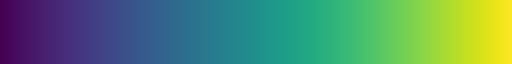

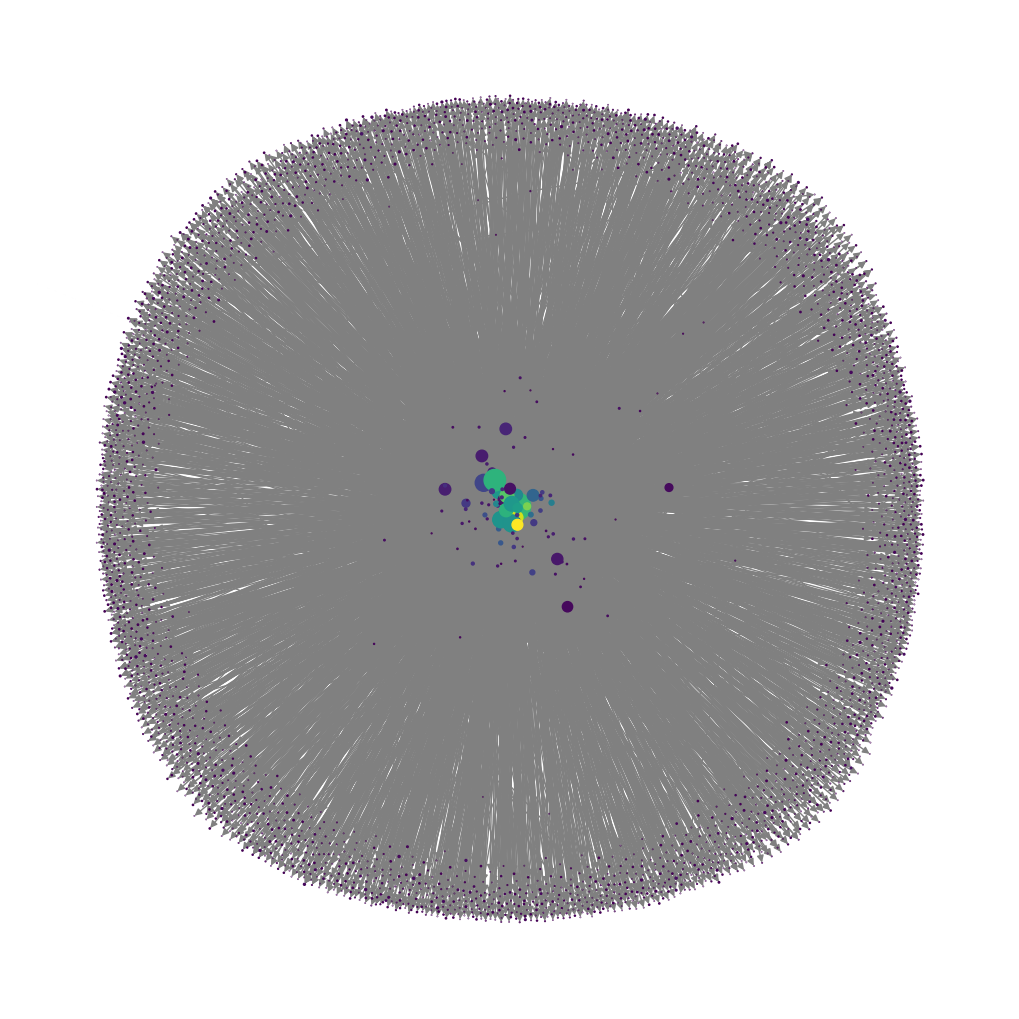

In [11]:
plt.figure(figsize=(10,10))
cmap = plt.cm.viridis

# pos = nx.nx_agraph.graphviz_layout(PPI_graph)
pos = nx.spring_layout(PPI_graph)
# pos = nx.spiral_layout(PPI_graph)
nx.draw(PPI_graph, node_color=node_color, edge_color="gray", pos=pos,
         font_color='white', font_weight='bold', node_size=node_size, cmap = cmap)
plt.cm.viridis

### Transitivity of Original Interactome (directed)

In [21]:
transitivity_value = nx.transitivity(PPI_graph)


0.06446546978382366

In [22]:
round(transitivity_value,4)

0.0645

### Transitivity of Indirect Interactome & Random Graph 


In [19]:
PPI_graph_undirected = copy.deepcopy(PPI_graph).to_undirected()

original_transitivity = nx.transitivity(PPI_graph_undirected)

In [20]:
original_transitivity

0.06792585348708537

In [17]:
random_graph = nx.gnm_random_graph(PPI_graph.number_of_nodes(), PPI_graph.number_of_edges())

random_transitivity = nx.transitivity(random_graph)


In [18]:
random_transitivity

0.0041422916204966785

### Checking the clustering Coefficient (local measure)

In [12]:
PPI_graph_undirected = copy.deepcopy(PPI_graph).to_undirected()

original_clustering_coefficient = nx.average_clustering(PPI_graph_undirected)

In [13]:
random_graph = nx.gnm_random_graph(PPI_graph_undirected.number_of_nodes(), PPI_graph_undirected.number_of_edges())

random_clustering_coefficient = nx.average_clustering(random_graph)

In [14]:
print("Original PPIN Clustering Coefficient:", original_clustering_coefficient)
print("Random Graph Clustering Coefficient:", random_clustering_coefficient)

Original PPIN Clustering Coefficient: 0.1351218543442854
Random Graph Clustering Coefficient: 0.0021994654311694554


**This could mean that proteins in the network tend to form clusters or groups where the proteins are densely interconnected.**

## Acyclic Shortest Paths 

* In the context of Protein-Protein Interaction (PPI) networks, an acyclic graph implies that there are no sequences of interactions that form closed loops or **feedback loops**.
* If you have acyclic paths between two proteins, it implies that there is a directed flow of interactions from one protein to another without forming any closed loops. This can be valuable information in understanding the flow of information or processes in biological systems.


### Testing in Lower Scale

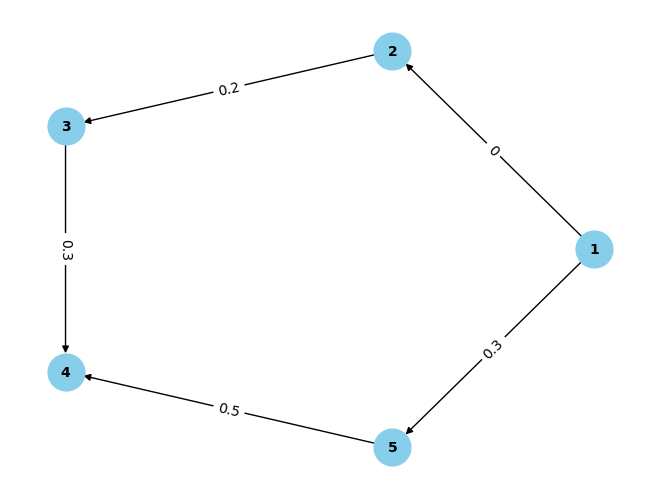

In [39]:
G = nx.DiGraph()
G.add_edges_from([(1, 2, {'weight': 0}), (2, 3, {'weight': 0.2}), (3, 4, {'weight': 0.3}), (1, 5, {'weight': 0.3}),(5, 4, {'weight': 0.5})])
# ,(2, 3, {'weight': 1})
# Specify the layout for better visualization
pos = nx.circular_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels);


## the acyclic shortest paths

In [24]:
def generate_graph(path_nodes, edge_weights):
    """
    Generate a directed graph based on a list of paths
    Parameters:
    - path_nodes (list): A list of paths, where each path is represented as a list of nodes
    - edge_weights (list): A list of lists containing edge weights corresponding to each path
    Returns:
    - G (DiGraph): A directed graph representing the paths
    """
    G = nx.DiGraph()
    for path, weights in zip(path_nodes, edge_weights):
        for (source, target), weight in zip(list(zip(path[:-1], path[1:])), weights):
            G.add_edge(source, target, weight=weight)
    return G 


def plot_graph(G, pos, ax, path_nodes, total_scores):
    """
    Plot the directed graph along with path information.
    Parameters:
    - G (DiGraph): A directed graph.
    - pos (dict): A dictionary with node positions for the graph
    - ax (matplotlib.axes.Axes): The axes on which to draw the graph
    - path_nodes (list): A list of paths, where each path is represented as a list of nodes
    - total_scores (list): A list of total scores corresponding to each path
    """
    colormap = plt.cm.get_cmap('viridis', len(path_nodes))
    table_data = [["Total Score"]]
    custom_legend = []
    for i, path in enumerate(path_nodes):
        path_edges = list(zip(path[:-1], path[1:]))
        color = to_rgba(colormap(i))  
        nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue', ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=[color], ax=ax)
        nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'weight'))
        nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=8, font_color='black', ax=ax)  
        table_data.append([f"{total_scores[i]:.4f}"])
        custom_legend.append(Line2D([0], [0], color=color, lw=2, label=f"Path {i + 1}"))
    ax.legend(handles=custom_legend, loc='upper left')
    table = ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='bottom', bbox=[0, -0.1, 1, 0.1])
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    ax.set_title("DAC with K-Shortest-Paths")
    
def calculate_path_score(graph, path):
    """
    Calculate the score of a path in a graph based on edge weights.
    Parameters:
        graph (NetworkX graph): The graph containing edge weights.
        path (list): The list of nodes representing the path.
    Returns:
        tuple: A tuple containing the total score of the path and a list of individual edge weights.
    """
    score_list = list()
    score = 1
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        if graph.has_edge(u, v):
            weight = graph.get_edge_data(u,v)['weight']
            score *= 10**(-weight)
            score_list.append(round(10**(-weight),3))
    return (round(score,3), score_list)


def Export_PDF(graph,path_nodes, total_scores, pdf_filename):
    """
    Export a PDF file containing a plot of the directed graph with path information.
    Parameters:
    - graph (DiGraph): A directed graph representing the network.
    - path_nodes (list): A list of paths, where each path is represented as a list of nodes
    - total_scores (list): A list of total scores corresponding to each path
    - pdf_filename (str): The name of the PDF file to be created
    # """

    if not np.any(path_nodes):
        print("terminate")
        return 
    weight_list = list() 
    for path in path_nodes:
        weight_list.append(calculate_path_score(graph, path)[1])
    G = generate_graph(path_nodes,weight_list)
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(5, 5))  
        plot_graph(G, pos, ax, path_nodes, total_scores)
        pdf.savefig(fig)
        plt.close(fig)

In [25]:
def is_acyclic(graph, path):
    # Check if adding the next edge creates a cycle
    graph_copy = copy.deepcopy(graph)
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        if graph_copy.has_edge(u, v):
            graph_copy.remove_edge(u, v)
            if nx.has_path(graph, v, u):  # Check if there is a path back to the source
                graph_copy.add_edge(u, v)
                print(f"there is a feedback loop between: {(u , v)}")
                return False
            graph_copy.add_edge(u, v)
    return True


def find_acyclic_K_shortest_paths(graph, source, target, pdf_filename, k=100):
    """
    Find the top K acyclic shortest paths in a directed graph and export a PDF with visualization.
    Parameters:
    - graph (DiGraph): A directed graph.
    - source (node): The starting node for paths.
    - target (node): The target node for paths.
    - pdf_filename (str): The name of the PDF file to be created.
    - k (int): The number of top paths to find (default is 100).
    """
    graph_copy = graph.copy()
    for u, v, data in graph_copy.edges(data=True):
        probability = data.get("weight")
        if probability == 0:
            data['weight'] = np.Inf
        else:
            data['weight'] = round(-log10(probability),3)
        
    K_shortest_paths = list(nx.shortest_simple_paths(
        graph_copy, source, target, weight="weight"))  # using Yen's algorithm
    print(f"All paths before cyclic filtration:{K_shortest_paths}")
    K_acyclic_shortest_paths = np.array(
        [path for path in K_shortest_paths if is_acyclic(graph_copy, path)], dtype=object)
    print(f"All paths after cyclic filtration:{K_acyclic_shortest_paths}")
    paths_score = np.array([calculate_path_score(graph_copy, path)[
        0] for path in K_acyclic_shortest_paths])
    non_zero_paths_score = np.where(paths_score != 0)[0][:k]
    K_acyclic_shortest_paths = K_acyclic_shortest_paths[non_zero_paths_score]
    paths_score = paths_score[non_zero_paths_score]
    Export_PDF(graph_copy, K_acyclic_shortest_paths, paths_score, pdf_filename)



In [40]:
file_path = "Exported_files/acyclic_shortest_paths_test1.pdf"
find_acyclic_K_shortest_paths(G, 1, 4,file_path)


All paths before cyclic filtration:[[1, 5, 4], [1, 2, 3, 4]]
All paths after cyclic filtration:[list([1, 5, 4]) list([1, 2, 3, 4])]


### Apply to Real PPIs 

In [874]:
record = df.loc[1,:]
print(record)
source = record[0]
target = record[1]
true_score = record[2]
file_path = "Exported_files/acyclic_shortest_paths_test1.pdf"
find_acyclic_K_shortest_paths(PPI_graph,source,target,file_path)

#tail                                                Q8TBF4
head                                                 Q15717
edge_weight                                        0.311133
edge_type      MI:0004 (affinity chromatography technology)
Name: 1, dtype: object
[['Q8TBF4' 'Q15717']] [0.31113]


### Path Generator for testing

In [30]:
def generate_path(graph):
    no_nodes = graph.number_of_nodes()
    list_of_nodes = list(graph.nodes())
    while True:
        candidate_nodes_indices = random.sample(range(no_nodes),2)
        v, u = list_of_nodes[candidate_nodes_indices[0]], list_of_nodes[candidate_nodes_indices[1]]
        if not graph.has_edge(v,u) and nx.has_path(graph,v,u):
            return v,u


In [36]:
source, target = generate_path(PPI_graph)
print(source,target)
file_path = "acyclic_shortest_paths_test2.pdf"
find_acyclic_K_shortest_paths(PPI_graph,source,target,file_path,2)

P39023 Q9NWT8
All paths before cyclic filtration:[['P39023', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P05387', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P05388', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P05387', 'P05388', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P05388', 'P05387', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P40429', 'P05387', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P40429', 'P05388', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P40429', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P40429', 'P05387', 'P05388', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P40429', 'P05388', 'P05387', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P05387', 'P40429', 'P05388', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P05388', 'P40429', 'P05387', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P05387', 'P40429', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P05388', 'P40429', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P05387', 'P05388', 'P40429', 'P05386', 'Q9H840', 'Q9NWT8'], ['P39023', 'P05388',

In [37]:
# after trial
source = "Q00535" 
target = "P14373"   
file_path = "acyclic_shortest_paths_test2.pdf"
find_acyclic_K_shortest_paths(PPI_graph,source,target,file_path,2)

All paths before cyclic filtration:[['Q00535', 'Q9NXR1', 'P14373']]
All paths after cyclic filtration:[['Q00535' 'Q9NXR1' 'P14373']]


In [41]:
print(PPI_graph.has_edge("Q00535","Q9NXR1")) # no feedback loop 
print(nx.has_path(PPI_graph,"Q9NXR1", "Q00535"))

True
False


In [688]:
# list paths' (source & target) that are acyclic  all of them of length 3 (small world effect)
path_list = [("Q9NXR8", "Q92793"), ("Q00535","P14373"),("Q00535","Q9BRK4"),("Q92831","A8MW92"),("Q92831","Q9UBN7"),
             ("Q9NXR8","Q9Y618"),("Q9NXR8","Q9UKV0"),("Q9NXR8","O14744"),("Q92831","Q9BY41"),
             ("Q92831","P28749"),("Q9NXR8","P02751"),("Q92831","Q15573"),("Q9NXR8","O75376"),
             ("Q9NXR8","Q96NS5"),("Q9NXR8","P00533"),("Q00535","Q08379"),("Q92831","Q93034"),
             ("Q9NXR8","P10070"),("Q9NXR8","Q9BW71"),("Q9NXR8","Q04206"),("Q92831","Q8IZL8"),
             ("Q9NXR8","Q8WTS6"),("Q92831","P11509"),("Q9NXR8","P33993"),("Q9NXR8","Q14997"),
             ("Q9NXR8","Q9UBU9"),("Q9NXR8","Q14566"),("Q92831","Q6PL18"),("Q9NXR8","O14929")
             ("Q92831","Q14134"),("Q92831","A8MW92")]

# candidates for hubs ("Q9NXR8", "Q00535", "Q92831") most repeated in acyclic paths, they act as source 
# targets are unique
# a question is raised about these candidates. lists report about its degree

In [69]:
# examine the most repeated source that results in a path without feedback
print("the degree and betweenness centrality of some nodes")
print(f"Degree of Q9NXR8: {PPI_graph.degree('Q9NXR8')}",  f"Betweenness Centrality of Q9NXR8: {betCent['Q9NXR8']}")
print(f"Degree of Q00535: {PPI_graph.degree('Q00535')}",  f"Betweenness Centrality of Q00535: {betCent['Q00535']}")
print(f"Degree of Q92831: {PPI_graph.degree('Q92831')}",  f"Betweenness Centrality of Q92831: {betCent['Q92831']}")
# print("the degree of the target nodes")
# print(PPI_graph.degree("Q9BY41"))
# print(PPI_graph.degree("Q8IZL8"))
# print(PPI_graph.degree("P00533"))


the degree and betweenness centrality of some nodes
Degree of Q9NXR8: 100 Betweenness Centrality of Q9NXR8: 0.00018629073648931507
Degree of Q00535: 260 Betweenness Centrality of Q00535: 0.0006500264567123014
Degree of Q92831: 427 Betweenness Centrality of Q92831: 0.0007371689083335975


In [737]:
# let's examine the paths that are most rejected, and see the nature of the source nodes. The majority are 4 in length.
most_reject_paths = [("P05388","O60216"),("Q15572","Q9Y383"),("Q92833","P31327"),
                     ("P20933","P40692"),("P02765","Q11203"),("Q9H840","O14979"),("P02766","P49619"),
                     ("P02766","P00734"),("P00734","P62753"),("P40429","Q14103"),("P02768","Q01850"),
                     ("P02766","Q9Y3A3"),("P05387","Q8NHV4"),("Q9UBM7","P36406"),("Q9H840","P49757"),
                     ("Q9UBM7","Q9H1K0"),("P05387","Q9NPI1"),("P05387","P56134"),("P02765","O75496"),
                     ("P05388","Q9NZI8"),("P20933","O60925"),("P39023","Q8IXZ2"),("P02760","P23396"),
                     ("Q9UBM7","Q9UKR5"),("Q15572","Q9UHJ3")]
# often the longer paths always have a feedback at its beginning 

In [740]:
print("the degree of the source nodes")
print(PPI_graph.degree("Q9UBM7"))
print(PPI_graph.degree("P02766"))
print(PPI_graph.degree("P05387"))
print("the degree of the target nodes")
print(PPI_graph.degree("P62753"))
print(PPI_graph.degree("O75496"))
print(PPI_graph.degree("Q9UHJ3"))


the degree of the source nodes
18
63
157
the degree of the target nodes
5
1
2


## Get Successors & predecessors of a Node 

In [130]:
df.head()

,#tail,head,edge_weight,edge_type
0,Q8TBF5,Q9UKB1,0.311133,MI:0004 (affinity chromatography technology)
1,Q8TBF4,Q15717,0.311133,MI:0004 (affinity chromatography technology)
2,Q8TBF4,P08865,0.311133,MI:0004 (affinity chromatography technology)
3,Q8TBF4,Q02539,0.311133,MI:0004 (affinity chromatography technology)
4,Q8TBF4,Q96J01,0.201461,MI:0401 (biochemical)


In [131]:
tail_counter = Counter(df["#tail"])
head_counter = Counter(df["head"])

most_tail_repeated = tail_counter.most_common(1)[0]
most_head_repeated = head_counter.most_common(1)[0]
print(most_tail_repeated, "the most repeated head")
print(most_head_repeated, "the most repeated tail")

('P05388', 220) the most repeated head
('Q15717', 13) the most repeated tail


## Protein Degree


In [132]:
def get_node_predecessors(graph,protein_of_interest): 
    k = graph.in_degree(protein_of_interest) # degree of such node
    predecessors = list(graph.predecessors(protein_of_interest))
    weight_list = list()
    for protein in predecessors:
        weight_list.append(edge_weights[(protein,protein_of_interest)])
    return k, list(zip(predecessors,weight_list))  # in_degree, in_conneced_proteins

def get_node_successors(graph,protein_of_interest):
    k = graph.out_degree(protein_of_interest) # degree of such node
    successors = list(graph.successors(protein_of_interest))
    weight_list = list()
    for protein in successors:
        weight_list.append(edge_weights[(protein_of_interest,protein)])
    return k, list(zip(successors,weight_list))  # out_degree, out_conneced_proteins

def export_protein_data(graph, protein_of_interest, file_name):
    """
    Export protein data, including in-degree and out-degree information, to a text file.
    Parameters:
        graph (NetworkX graph): The graph containing protein interaction data.
        protein_of_interest (str): The name of the target protein.
        file_name (str): The name of the output text file.
    Returns:
        None: The function writes the protein data to the specified file.
    Notes:
        The function calculates the in-degree and out-degree of the target protein,
        retrieves the connections with their weights, and writes the information
        to the specified text file. If there are no in-degree or out-degree connections,
        appropriate messages are written to the file.
    """
    in_degree_data = get_node_predecessors(graph,protein_of_interest)
    out_degree_data = get_node_successors(graph,protein_of_interest)
    with open(file_name, 'w') as file:
        file.write(f"target protein name:{protein_of_interest}\n")
        file.write(f"# in degree:{in_degree_data[0]}\n")
        file.write(f"# out degree:{out_degree_data[0]}\n")
        file.write("\nin_degree_connections::\n")
        if in_degree_data[0] > 0:  # Check if in_degree is greater than 0
            for connection in in_degree_data[1]:
                file.write(f"{connection[0]} || {connection[1]}\n")
        else:
                file.write("There's No In Degree Connection\n")
        file.write("\nout_degree_connections::\n")
        if out_degree_data[0] > 0:  # Check if out_degree is greater than 0
            for connection in out_degree_data[1]:
                file.write(f"{connection[0]} || {connection[1]}\n") 
        else:
                file.write("There's No Out Degree Connection\n")

In [133]:
export_protein_data(PPI_graph, most_head_repeated[0], "protein_data.txt")

## Histogram 

In [5]:
def draw_degree_histogram(graph, protein_set, output_pdf, flag="all"):
    """
    Draw a histogram of protein degrees and save the sorted degree data to a text file.
    Parameters:
        graph (NetworkX graph): The graph containing protein interaction data.
        protein_set (list): List of protein names.
        output_pdf (str): The name of the output PDF file for the histogram and degree data.
        flag (str): Specifies the type of degree to consider ("all", "in", or "out").
    Returns:
        None: The function displays the histogram and saves the degree data to a text file.
    Notes:
        The function calculates the specified type of degree for each protein in the input set,
        draws a histogram, and saves the sorted degree data to a text file. The histogram is displayed,
        and the degree data includes the protein names and their corresponding degrees.
    """
    degree_function = {"all": graph.degree,
                       "in": graph.in_degree,
                       "out": graph.out_degree}
    protein_degrees = np.array([degree_function[flag](protein) for protein in protein_set])
    sorted_degrees_indices = np.argsort(protein_degrees)[::-1]
    sorted_degrees = protein_degrees[sorted_degrees_indices]
    protein_set = np.array(protein_set)[sorted_degrees_indices]
    _, ax = plt.subplots(figsize=(5, 5))
    ax.hist(sorted_degrees, bins=30, color='skyblue', edgecolor='black',  density=True)
    ax.set_title('Degree Distribution')
    ax.set_xlabel('Total Degree')
    ax.set_ylabel('Probability')
    plt.show()
    degree_file= open(output_pdf,'w')
    with open(output_pdf, 'w') as degree_file:
        degree_file.write(f"protein_name  {flag}_degree\n")
        degree_file.write("-----------------------\n")
        for protein, degree in zip(protein_set, sorted_degrees):
            degree_file.write(f"{protein} \t\t  {degree}\n")
    

17168


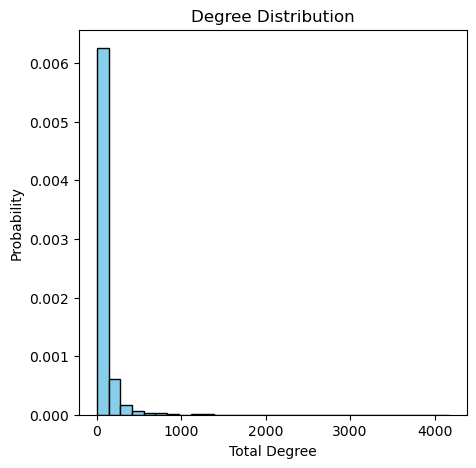

In [6]:
protein_set = list(PPI_graph.nodes())
print(len(protein_set))
draw_degree_histogram(PPI_graph,protein_set,"degree_report.txt",flag = "all")

## Conversion Map 

In [136]:
from bioservices import UniProt

def get_conversion_map(uniprot_ids):
    # Create a UniProt service instance
    lookup = dict()
    u = UniProt()
    # Fetch UniProt entries for the given IDs\
    for protein in uniprot_ids:
        gene_namse = u.get_df(protein)["Gene Names"]
        if isinstance(gene_namse.values[0],str): 
            lookup[protein] = gene_namse.str.split(" ").values[0]
        else:
            lookup[protein] = gene_namse.values[0]
    return lookup

In [139]:
uniprot_ids = list(PPI_graph.nodes())[:100]
conversion_map = get_conversion_map(uniprot_ids)
conversion_map

{'Q8TBF5': ['PIGX'],
 'Q9UKB1': ['FBXW11', 'BTRCP2', 'FBW1B', 'FBXW1B', 'KIAA0696'],
 'Q8TBF4': ['ZCRB1'],
 'Q15717': ['ELAVL1', 'HUR'],
 'P08865': ['RPSA', 'LAMBR', 'LAMR1'],
 'Q02539': ['H1-1', 'H1F1', 'HIST1H1A'],
 'Q96J01': ['THOC3'],
 'P51148': ['RAB5C', 'RABL'],
 'Q8NI27': ['THOC2', 'CXorf3'],
 'Q15696': ['ZRSR2', 'U2AF1-RS2', 'U2AF1L2', 'U2AF1RS2', 'URP'],
 'O43660': ['PLRG1'],
 'Q15527': ['SURF2'],
 'P15880': ['RPS2', 'RPS4'],
 'Q9UGY1': ['NOL12'],
 'Q96HE9': ['PRR11'],
 'Q6I9Y2': ['THOC7', 'NIF3L1BP1'],
 'Q8N5P1': ['ZC3H8', 'ZC3HDC8'],
 'Q5MIZ7': ['PPP4R3B', 'KIAA1387', 'PP4R3B', 'SMEK2'],
 'Q8N490': ['PNKD', 'KIAA1184', 'MR1', 'TAHCCP2', 'FKSG19', 'UNQ2491/PRO5778'],
 'Q53ET0': ['CRTC2', 'TORC2'],
 'P51648': ['ALDH3A2', 'ALDH10', 'FALDH'],
 'P04629': ['NTRK1', 'MTC', 'TRK', 'TRKA'],
 'P46379': ['BAG6', 'BAT3', 'G3'],
 'P16104': ['H2AX', 'H2AFX'],
 'Q99689': ['FEZ1'],
 'P62714': ['PPP2CB'],
 'Q9H3S7': ['PTPN23', 'KIAA1471'],
 'Q16719': ['KYNU'],
 'Q86VU5': ['COMTD1', 'UNQ766/P

In [140]:
# debugging efforts. 
print(f"Number of UniProt IDs from graph: {len(uniprot_ids)}")
print(f"Number of UniProt IDs in conversion map: {len(conversion_map)}")
missing_data = list()
for protein in uniprot_ids:
    if not protein in conversion_map:
        missing_data.append(protein)
print(missing_data)

Number of UniProt IDs from graph: 100
Number of UniProt IDs in conversion map: 100
[]


In [141]:
curr_protein = 'Q9Y2S0'
u = UniProt()
entries = u.get_df(curr_protein)
entries # the gene name is not known 

,Entry,Entry Name,Gene Names,Gene Names (primary),Gene Names (synonym),Gene Names (ordered locus),Gene Names (ORF),Organism,Organism (ID),Protein names,...,Glycosylation,Initiator methionine,Lipidation,Modified residue,Peptide,Post-translational modification,Propeptide,Signal peptide,Transit peptide,PDB
0,Q9Y2S0,RPAC2_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,demerged,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
curr_protein = 'Q8NI27'
u = UniProt()
entries = u.get_df(curr_protein)
entries # the gene name is not known 

,Entry,Entry Name,Gene Names,Gene Names (primary),Gene Names (synonym),Gene Names (ordered locus),Gene Names (ORF),Organism,Organism (ID),Protein names,...,Glycosylation,Initiator methionine,Lipidation,Modified residue,Peptide,Post-translational modification,Propeptide,Signal peptide,Transit peptide,PDB
0,Q8NI27,THOC2_HUMAN,THOC2 CXorf3,THOC2,CXorf3,NaN,NaN,Homo sapiens (Human),9606,THO complex subunit 2 (Tho2) (hTREX120),...,NaN,NaN,NaN,"MOD_RES 1222; /note=""Phosphoserine""; /evidence...",NaN,NaN,NaN,NaN,NaN,7APK;7ZNK;7ZNL;


## Convert To adjacency Matrix 

In [161]:
def convert_to_unweighted_graph(graph): 
    unweighted_graph = graph.copy()
    for _,_, data in unweighted_graph.edges(data=True):
        data["weight"] = 1
    return unweighted_graph


In [158]:
unweighted_graph = convert_to_unweighted_graph(PPI_graph)

In [160]:
adjacency_matrix = nx.adjacency_matrix(unweighted_graph)
df = pd.DataFrame.sparse.from_spmatrix(adjacency_matrix, index=list(PPI_graph.nodes()), columns=list(PPI_graph.nodes()))
df.head()

,Q8TBF5,Q9UKB1,Q8TBF4,Q15717,P08865,Q02539,Q96J01,P51148,Q8NI27,Q15696,...,P20292,Q9Y2X0,P63279,P01100,Q8NHM5,Q8TF68,Q9H161,Q9UNN4,P17947,P15976
Q8TBF5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q9UKB1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q8TBF4,0,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Q15717,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P08865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
df.to_csv("unweighted_graph.csv")